### 🚀 使用 `trl` 复刻 DeepSeek R1 强化学习技术：GRPO  
**目标：在 `Qwen2.5-0.5B-Instruct` 小模型上训练数学推理能力+格式化输出的能力**  

---

## 📌 项目简介  
本项目旨在借助 `trl`（Hugging Face 的 `transformers` 相关强化学习库），复现 **DeepSeek R1** 的 **GRPO（General Reinforced Preference Optimization）** 训练方法，并将其应用于 **Qwen2.5-0.5B-Instruct** 小尺寸模型，以提升其推理能力。  

---

## 🛠️ 训练步骤  
1. **准备数据**：使用openai/gsm8k数据集
2. **加载 `Qwen2.5-0.5B-Instruct` 模型**
3. **构造奖励模型**
4. **使用 `trl` 进行 GRPO 训练**  
5. **评估推理能力提升**  

---

## 📌 预期成果  
🎯 **在实际场景中复现GRPO** —— 小模型也能学会复杂逻辑推理  
🎯 **深入了解GRPO原理**



- 训练早期

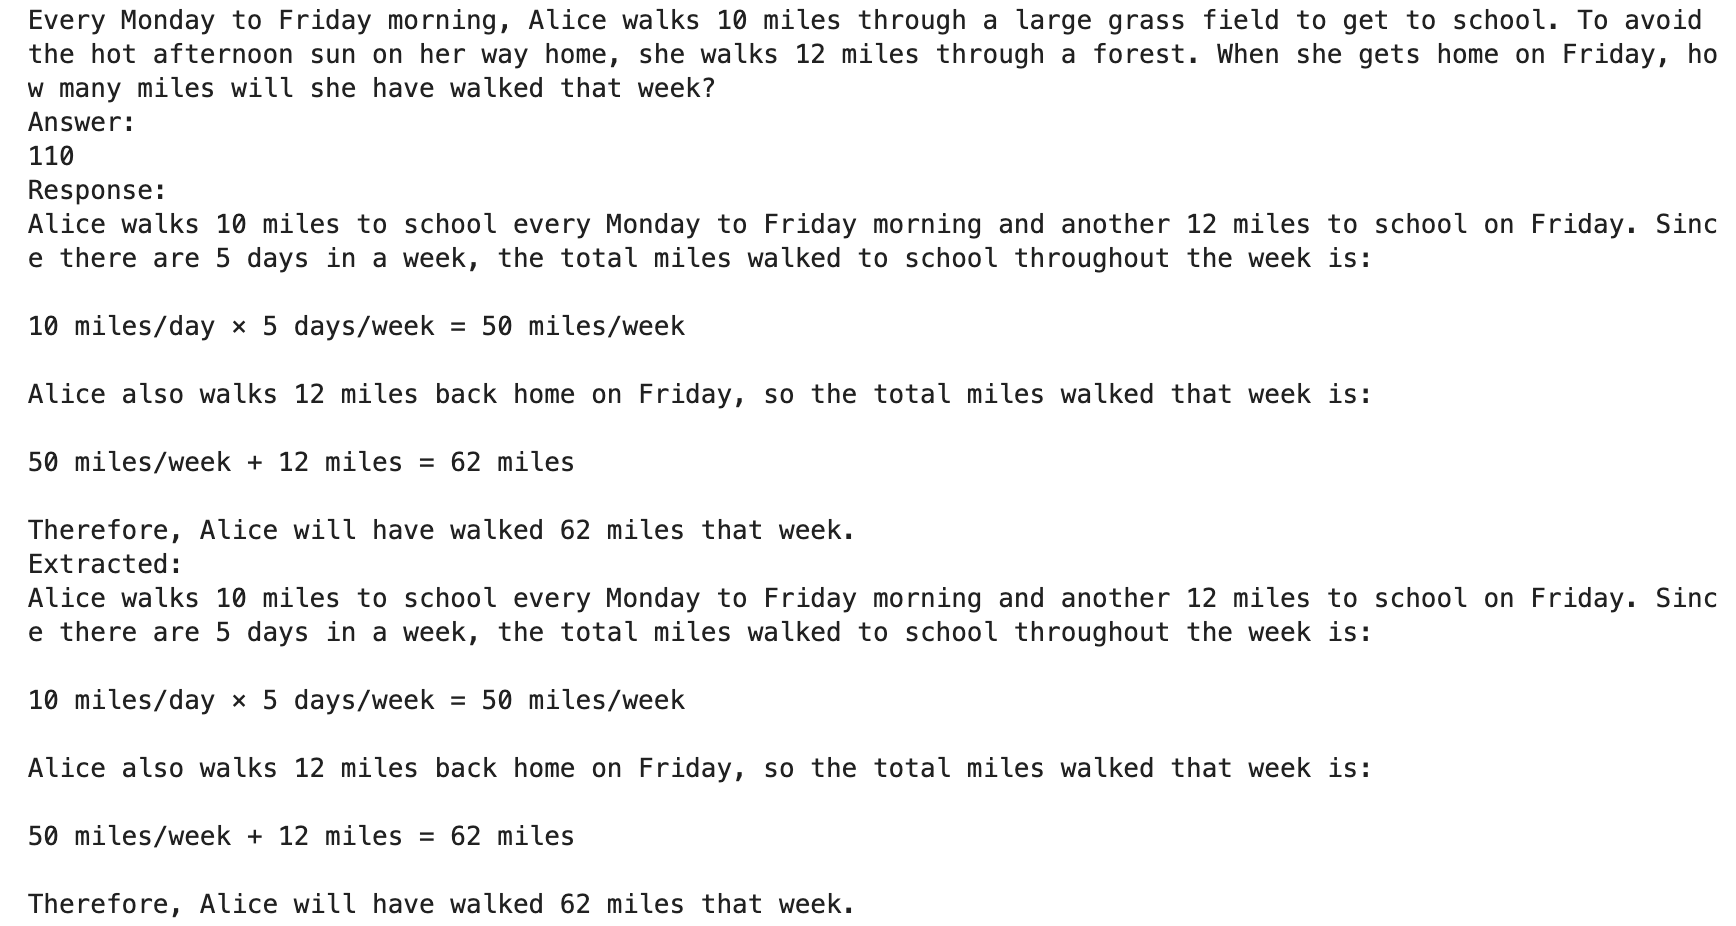

- 训练结束之后

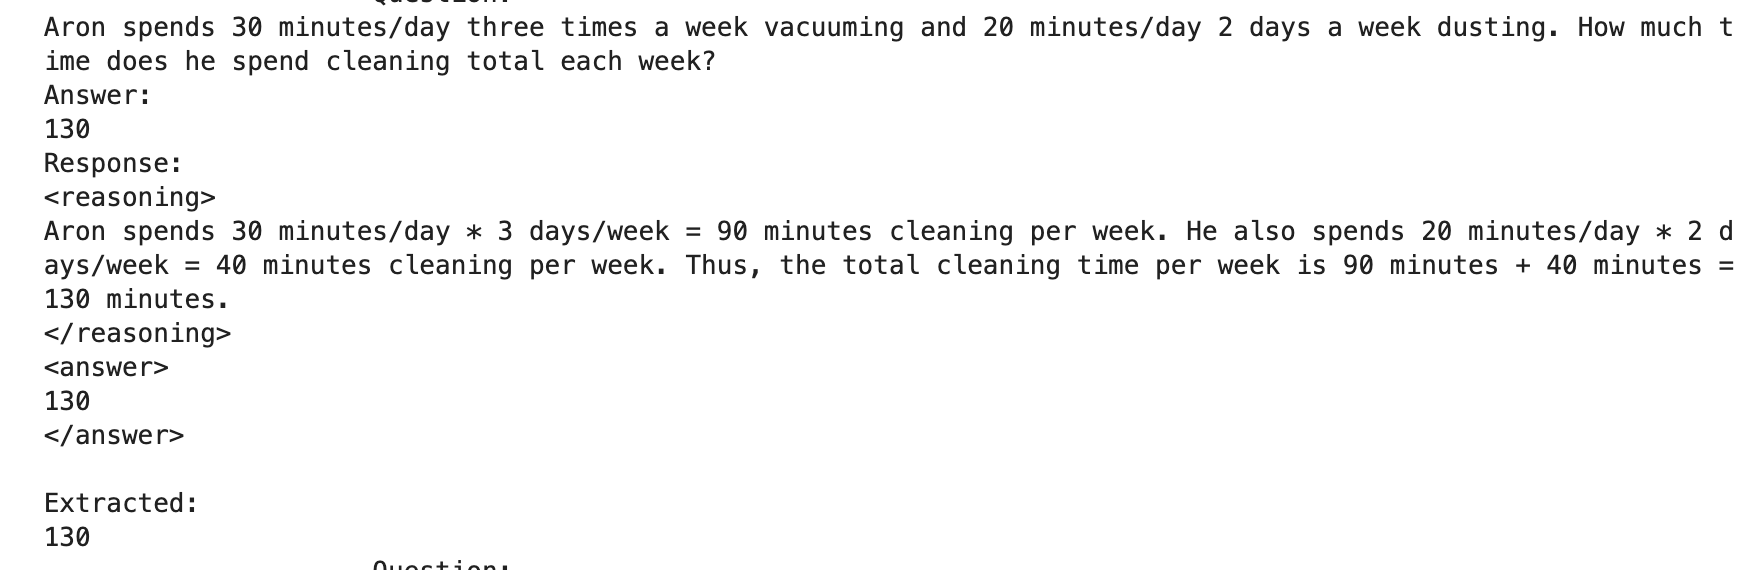

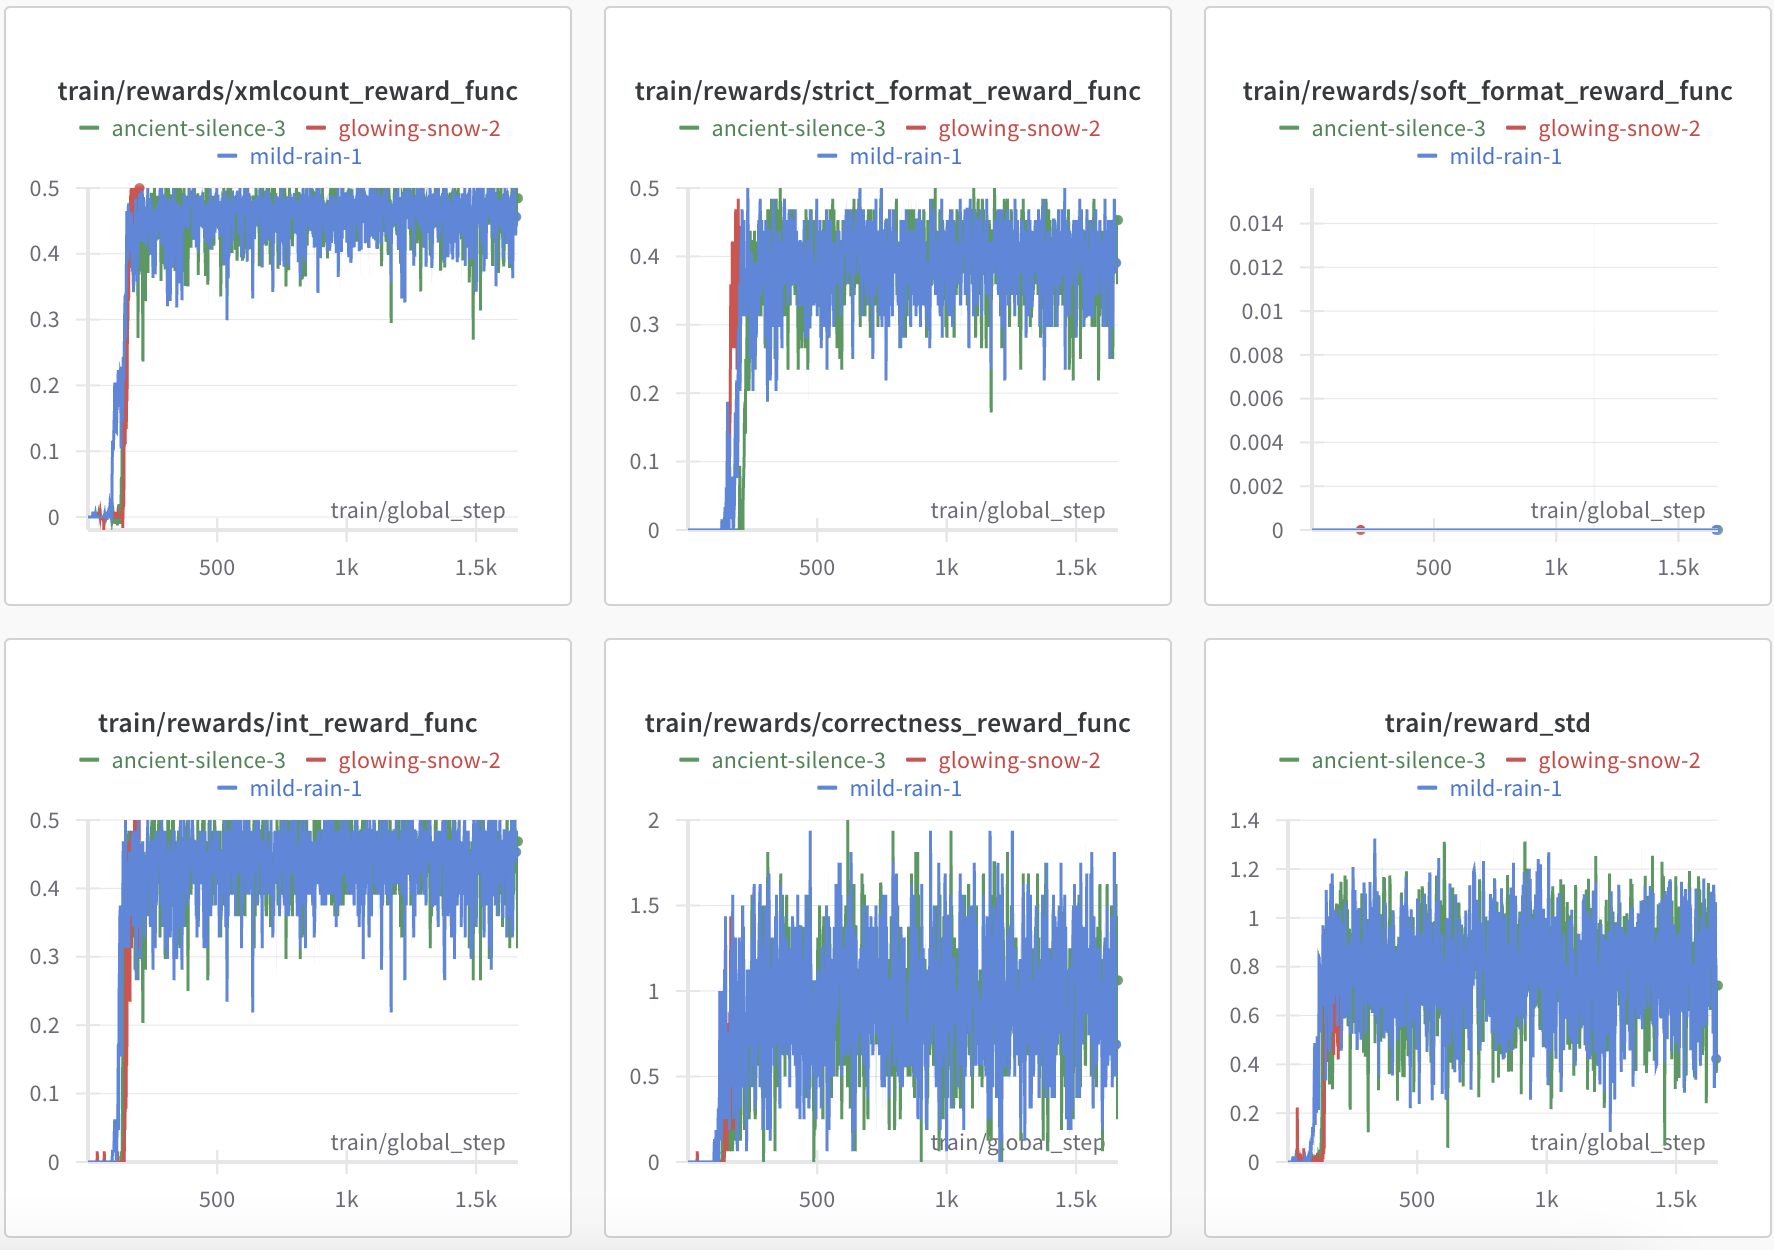

# 1.GRPO源码级理解

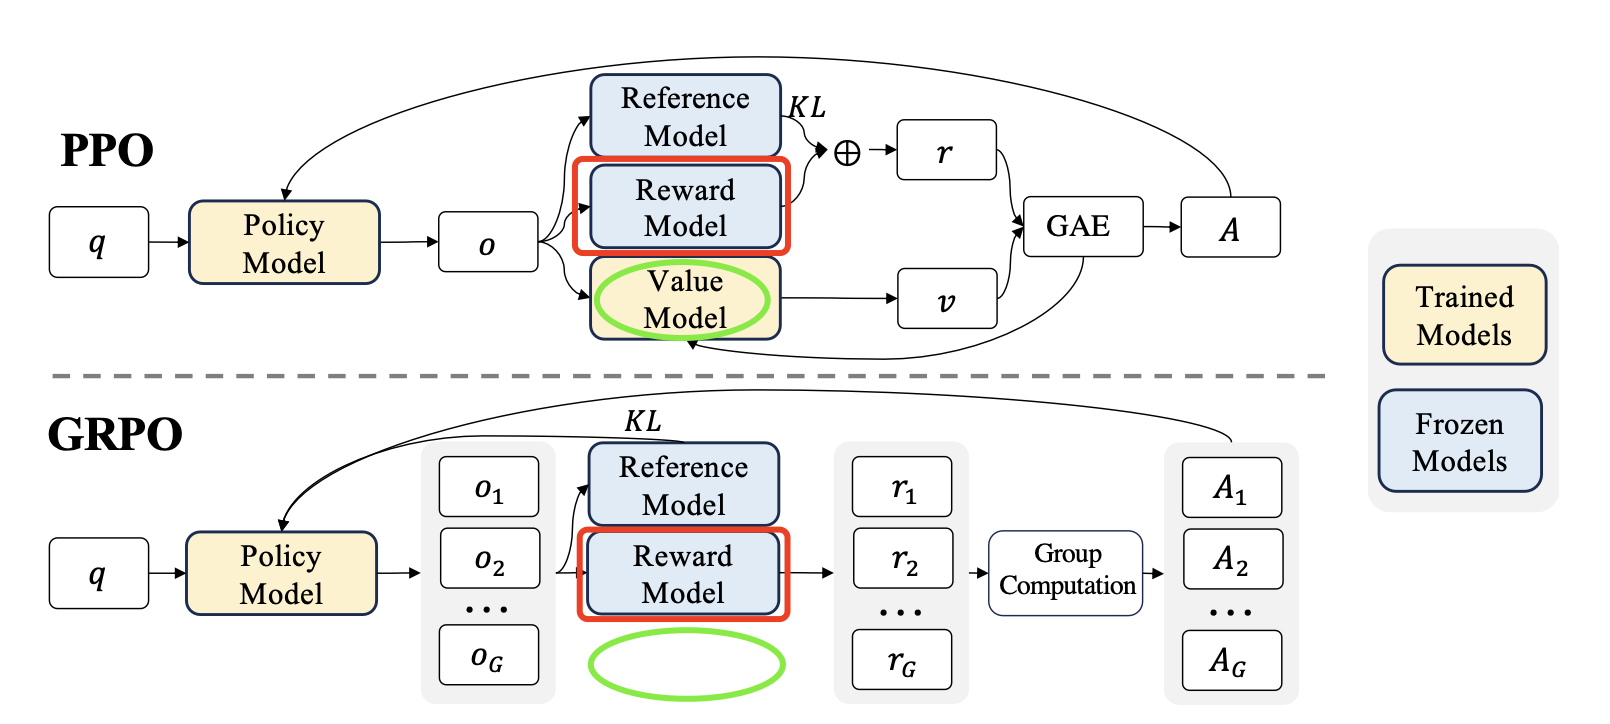

与PPO的两个核心区别

1. **Reward Model 不用训练，而是基于规则**  
   - 传统的 Reward Model 需要通过数据训练来学习奖励函数，而基于规则的 Reward Model 直接依赖于人工设定的规则，无需训练。

2. **不用训练 Value Model 去估计优势**  
   - 传统强化学习需要训练 Value Model 来估计状态或动作的价值（如 V(s) 或 Q(s, a)），从而计算优势（Advantage）。在某些方法下，可以直接使用策略梯度或基于规则的方式，而无需训练 Value Model 进行估计。


# 1. 问题设置

## 1.1 问题定义和评价标准

在DeepSeek-R1-Zero中，仅通过训练法就能提升模型的数学推理能力。我们给定数学问题，让模型进行回答，
将回答与标签判别正确性（o = y），给定n个问题，模型能够答对k个，则准确率为acc = k/n，那么我们的评价模型推理能力的标准是有更高的准确率。

对于选择题来说，模型的回答可以直接输出{A, B, C, D}之中的限定一个，但是对于数学解答题来说，模型要生成一个客观且格式一致的答案。如0 = 1/2，如果标签为y = 0.5，那么我们的指示函数的判别函数等于1：

I(1/2 = 0.5) = 1

以上的数学问题是特定标的，即一个问题对应一个客观的答案，但是客观的答案有多种表达形式，所以生成答案与标签的数学含义是相等的，才能算是正确。这种特性让精准的标答一致性，并非严格意义上要求字符串匹配或答案映射的完美匹配。因此，0.5和1/2判别为对的，那么该标答与模型学习，造成收敛困难。

为了方便我们提取最终答案，我们可以要求模型输出正确答案时，以`\boxed{1/2}` latex格式进行包裹。

## 1.2 CoT与LongCoT

对于一个算术问题，我们通常有如下“提示词工程”手段来推断出模型的答案：

1. **直接回答**：让模型直接预测的最终答案，但通常准确率低。
2. **In-context Learning**：在提示词中增加example，来进行引导，比如在MMLU选择题中，让base模型参考例子来生成{A, B, C, D}中的一个选项。
3. **提示词工程Chain-of-Thought(CoT)**：在提示词中，加入一种结构化的解答形式的例子，帮助模型进行推理的思维链生成相似的格式化解答，增加回答正确率的可能性。
4. **Auto-CoT**：在引导CoT时针对不同类型的问题需要特定的示例，Auto-CoT提出一种“Let’s think step-by-step”的上链提示词，让模型自动构建解题思路。

上述这几种方法，通常可以显著程度的增强模型的推理能力。另外：

5. **LongCoT**：可以从更多的角度对普通CoT示例进行合成，对Base模型进行行列训练，将结构化推理能力加入到推理中，在更长的推理链上，我们使用one-shot的方法，得到更长的CoT也就是LongCoT。

我们比较方法2,3,4,5的实验结果，通常在基于模型的参数已经足够改变时，前者是从输入提示词进行附加的学习，后者是直接变更网络本身的（参数微调）。

**最终我们希望，能够让模型推理的答案准确，且面对一个数学问题时，inference能够以CoT形式推导出正确的答案。**



## 1.3 输入和输出

我们在进行训练时，通常要准备问题集，每个问题对应的答案标签。

- **模型输入**：问题
- **模型输出**：CoT解答和最终答案
- **判别**：最终答案和标签的一致性

## 1.4 GRPO优化算法

GRPO优化算法概述如下，我们对下述算法进行简要解释：

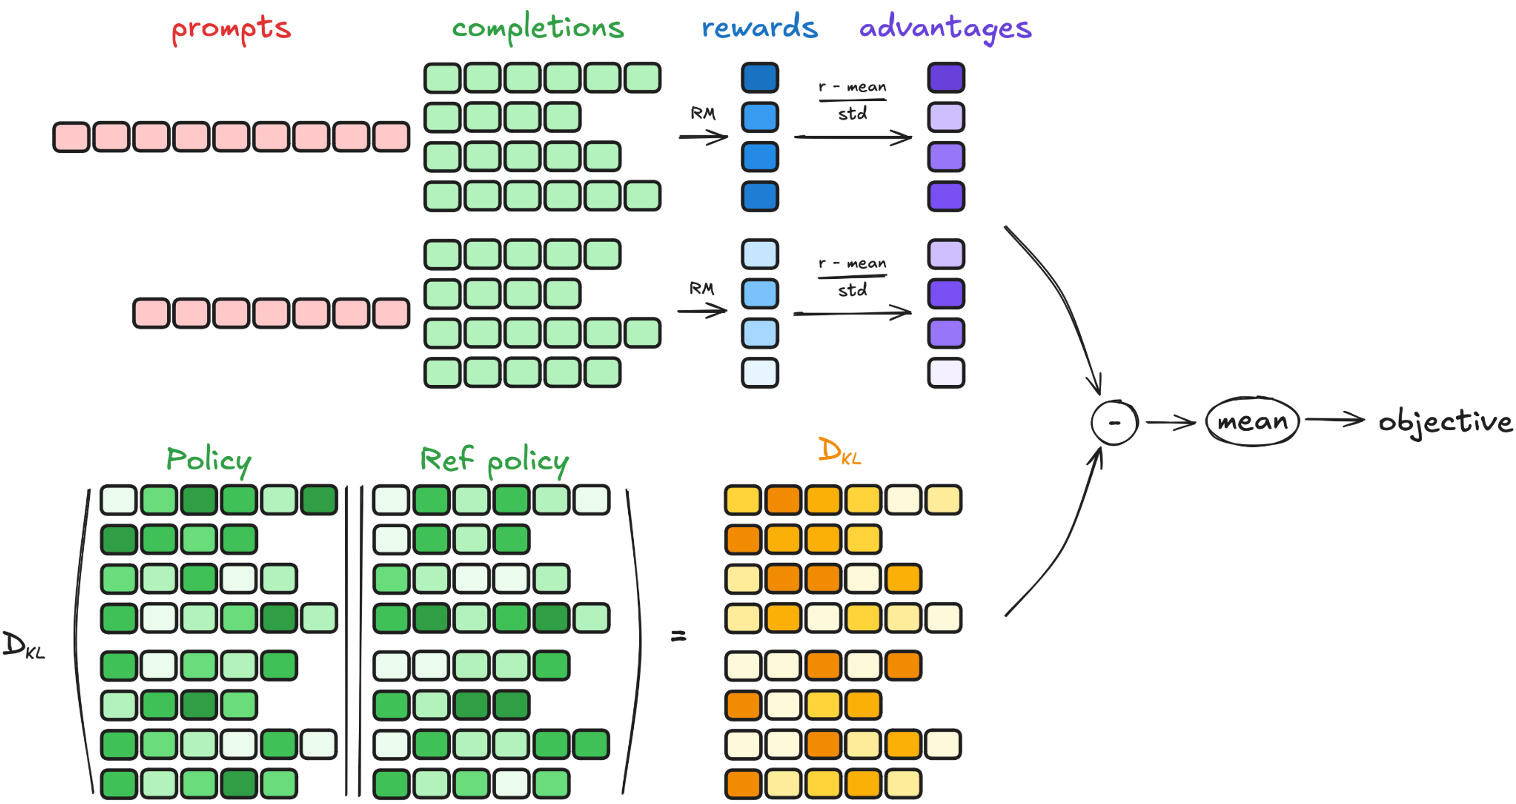

$$L_{GRPO}(\theta) = \frac{1}{G} \sum_{i=1}^{G} \sum_{t} \min \left( \frac{\pi_{\theta}(o_{i,t} | q, o_{i,<t})}{\pi_{old}(o_{i,t} | q, o_{i,<t})} \hat{A}_{i,t}, \ \text{clip}\left(\frac{\pi_{\theta}(o_{i,t} | q, o_{i,<t})}{\pi_{old}(o_{i,t} | q, o_{i,<t})}, 1 - \epsilon, 1 + \epsilon\right) \hat{A}_{i,t} \right)$$

$$D_{KL} [\pi_{\theta}||\pi_{ref}] = \sum_{i} \sum_{t} \pi_{\theta}(o_{i,t} | q, o_{i,<t}) \log \frac{\pi_{\theta}(o_{i,t} | q, o_{i,<t})}{\pi_{ref}(o_{i,t} | q, o_{i,<t})}$$


$$
\hat{A}_{i,t} = \frac{r_i - \text{mean}(r)}{\text{std}(r)}
$$
1. 对于模型给定一个问题 \(q\) 进行采样生成多个回答 \(o_{i,t}\)，\(i = 1,2,3,...,G\)，\(G\) 为 group 数量，而每个回答有不同的长度 \(|o_i|\)。
2. 模型和输出为在t时刻时候的采样策略。解码的第t个词元的策略概率。
3. KL 项约束策略分布不与原始策略分布 \(\pi_{\text{ref}}\) 有不能差异太大，这里采用一种优化的 KL 项，具有偏向方差小的特性。
4. \(r = \{r_1, r_2, ..., r_G\}\)，而 $$\hat{A}_{i,t}$$ 为组相对的优势。意味着一个回答的每个 token 的优势都是一样的。
# 2. 在线采样

## 2.1 格式化prompt

我们给定常规的回答模板，比如我们问：“如何写python程序”，通常需要进行格式化处理，并附上模型发言的前缀

```
#ASSISTANT:

#SYSTEM: 你需要友善的回答用户的问题
#USER: 如何写python程序
#ASSISTANT:
```

对于数学问题我们可以加上定义模版，在问题后面附上`<THINK>`。所以我们输入到模型里面的内容，也声明了回答的格式，仍然模型具备一定的结果随机化。

```
#SYSTEM: 你需要在<THINK>标签后面思考以<THINK>结尾，
答案部分则分别使用<ANSWER>和</ANSWER>，最终答案需以\boxed{}来处理。
#USER: 求解(x^3 - 3x +1)的极值
```

基于上述的提示词，我们可以对模型 \(\pi_\theta\) 进行采样出多条回答 \(o_i\)。回答的类型可能有

1. 没有答案
2. 没有过程
3. 过程有误
4. 最终答案与 \(\boxed{}\) 相符

### ```markdown
上述出错情况部分未遵循指令要求的格式输出。正确的模型输出格式为：

```markdown
<THINK>{SOLUTION} <\THINK>
<ANSWER> the final answer is $\boxed{1/2}$ <\answer>
```

## 2.2 说明

这里是 on-policy 采样，在 GRPO 相关论文里，采样的数量 \(G = 64\)，采样过程实际上是一种探索，如果能够探索到正确答案，得到正确的反馈。

所以在数学问题的 GRPO 优化中，我们不需要提前准备好解答过程 \({SOLUTION}\)，只需要让模型去采样(合成)数据。

在上述格式模版里我们可以约定 \(<THINK> {SOLUTION} <\THINK>\)， \({SOLUTION}\) 指代模型的 CoT 推理。

我们讨论两种样本，对于 GRPO 来说，哪个是更好的采样？

1. 生成的解决过程是错误的，但是答案错误
2. 生成的解决过程是错误的，但是答案正确

答案是 2，因为格式的数学问题，多数是结果导向的，而非过程。

那么又会产生新的疑问：

- Q1: 上述采样判断是否合理？
- Q2: 采样的解答过程是否会随着 RL 训练，采样的解答过程越来越严谨？

## 3. 奖励函数和优势

奖励通常有两种：

1. **model-based**: 通常需要有神经网络或者带学习参数的算法，对数据进行打分，如 preference reward，PRM。
2. **ruled-based**: 指的是按照一定的规则就能确认，如选择题的 ABCD 选项、字符串匹配和算术题数字，以及围棋，均可以通过确定的规则进行判别。

第一种（PPO），并没有参数对判别更直观且客观。

### 3.1 规则奖励

在模型的回答，我们要提取 1/2，与最终的结果比较 0.5。

```markdown
{SOLUTION} <THINK>
<ANSWER> the final answer is $\boxed{1/2}$ <\answer>
```

这可以为最终答案做比较，以便在数学方向上做要求答案一致，偏差太大。
```



```markdown

```
### 3.2 手撕 Advantage

在上述的奖励函数所得到的奖励，可以直接使用，我们根据 GRPO 的优势函数公式计算

$$
\hat{A}_{i,t} = \frac{r_i - \text{mean}(r)}{\text{std}(r)}
$$

其中 \(\hat{A}_{i,t}\) 里的 t 对应 token-level 优势，即一个句子中，每个 token 对应的优势是一样的。这种方式的好处在于，估计都是从真实的环境 reward 计算得来，而不是通过价值估计计算而得。

对应的代码实现为：

```python
def grpo_advantage(rewards):
    epsilon = 0.001 * torch.randn(1)
    rewards = torch.tensor(rewards, dtype=torch.float)
    A = (rewards - rewards.mean()) / (rewards.std() + epsilon)
    return A
```

测试时，我们假设采样 6 条输出，对应 6 个奖励。我们看 case2 里，正确项相对上的优势估计更大。而错误的回答将得到负的值。

当全错和全对时，优势是无效的，那么可以 skip 掉，如果 base 模型差无法采样到正确反馈，那么优化将会非常缓慢和不稳定。
```



# 4. GRPO KL

## 4.1 GRPO KL 无偏小方差

KL通常用于衡量两个概率分布的差异情况，标准的KL项为：

$$
D_{KL}[\pi_{\theta}||\pi_{ref}] = -\log \frac{\pi_{ref}(o_{i,t}|q, O_{i,<t})}{\pi_{\theta}(o_{i,t}|q, O_{i,<t})}
$$

GRPO采用以下形式的KL，相较于式上无偏小方差，将在下节分析

$$
D_{KL}[\pi_{\theta}||\pi_{ref}] = \frac{\pi_{ref}(o_{i,t}|q, O_{i,<t})}{\pi_{\theta}(o_{i,t}|q, O_{i,<t})} - \log \frac{\pi_{ref}(o_{i,t}|q, O_{i,<t})}{\pi_{\theta}(o_{i,t}|q, O_{i,<t})} - 1,
$$

将

$$
\gamma = \frac{\pi_{ref}(o_{i,t}|q, O_{i,<t})}{\pi_{\theta}(o_{i,t}|q, O_{i,<t})}
$$

则

$$
D_{KL}[\pi_{\theta}||\pi_{ref}] = (\gamma -1) - \log \gamma
$$



## 4.2 手撕GRPO KL

GRPO KL是token-level的

```python
def grpo_kl(pi_logprob, pi_ref_logprob):
    return pi_ref_logprob.exp() / pi_logprob.exp()- (pi_ref_logprob - pi_logprob) - 1

pi = torch.randn(3, 5) # batch, sequence
pi_ref = torch.randn(3, 5) # batch, sequence
pi_logprob = torch.nn.functional.log_softmax(pi, dim = 1)
pi_ref_logprob = torch.nn.functional.log_softmax(pi_ref, dim = 1)

print(grpo_kl(pi_logprob, pi_ref_logprob))
```

实现时，我们通常存储logprob，而不需要完整的输出分布来计算KL，减少存储占用。

### 输出

```
tensor([[0.1465, 0.0457, 0.5321, 0.0793, 0.0728],
        [1.1576, 3.0678, 0.5285, 0.3712, 0.0817],
        [0.0031, 0.8179, 2.4575, 0.1597, 0.0221]])
```

均为正数。与PPO不同，不产生reward shaping：\( R = r - KL \)


## 4.3 无偏小方差KL

根据[John Schulman：Approximating KL Divergence](https://arxiv.org/abs/1707.02247)

- **k1（naive estimator）**： $$\( \log \frac{p(x)}{q(x)} - \log r \)，其中 \( r = \frac{p(x)}{q(x)} \)。$$
  - 这个估计器是无偏的，但方差很大，因为它对一半的样本是负的即\( q(x) < p(x) \)，将导致估计值波动非常大。
  - 当\( q(x) \)差异大时，对数值也可能产生很大的变化。

- **k2（low variance estimator）**： $$\( \frac{1}{2} (\log \frac{p(x)}{q(x)})^2 = \frac{1}{2} (\log r)^2 \)$$。
  - 这个估计器是有偏的，但方差较低。
  - 由于其正偏很小，因为保证所有样本的值都是正的。

- **k3（unbiased low variance estimator）**： $$\( (r - 1) - \log r \)$$。 这个估计器是无偏的，并且方差较低。
  - 在1基础上增加\( (r - 1) \)项，减少方差。
  - \( r - 1 \)是无偏的。
  - \( r - 1 > \log r \)保证是无偏的。

---

## 4.4 手撕KL

```python
import torch.distributions as dis

p = dis.Normal(loc=0, scale=1)
q = dis.Normal(loc=0.1, scale=1)
x = q.sample(sample_shape=(10_000_000,))
truekl = dis.kl_divergence(p, q)
print("true", truekl)

logr = p.log_prob(x) - q.log_prob(x)
k1 = -logr
k2 = logr ** 2 / 2
k3 = (logr.exp() - 1) - logr

for k in (k1, k2, k3):
    print((k.mean() - truekl) / truekl, k.std() / truekl)
```

### 打印

```
Now let’s compare the bias and variance of the three estimators for KL[q,p]KL[q,p]. Suppose q=N(0,1)q=N(0,1), p=N(0.1,1)p=N(0.1,1). Here, the true KL is 0.005.
```



# 5. GRPO损失

## 5.1 GRPO损失项分析

GRPO loss看起来复杂，实际上，仅包含三部分：

1. 第一个连加的\( G \) 为一个样本的采样数量，第二个\( |o_i| \)是第\( i \)条输出的采样长度。
2. 在\( \min(\cdot, \cdot) \)里，与标准PPO差异不大，这里的advantage我们已经提前计算好了，在一条采样回答数据中对于不同的t 优势值都一样的。另外这里的ratio对比的是新旧策略。这个式子是token-level的。
3. KL项因子控制约束力度，KL计算的是新策略和参考策略。

$$
\mathcal{L}_{GRPO}(\theta) = -\frac{1}{G} \sum_{i=1}^{G} \frac{1}{|o_i|} \sum_{t=1}^{|o_i|} \min \left( \frac{\pi_\theta(o_{i,t} | q, O_{i,<t})}{\pi_{\theta_{old}}(o_{i,t} | q, O_{i,<t})} \hat{A}_{i,t}, \text{clip} \left( \frac{\pi_\theta(o_{i,t} | q, O_{i,<t})}{\pi_{\theta_{old}}(o_{i,t} | q, O_{i,<t})}, 1 - \epsilon, 1 + \epsilon \right) \hat{A}_{i,t} \right)
$$



## 5.2 手撕GRPO



```python
def grpo_loss(pi_logprob, pi_old_logprob, pi_ref_logprob, advantage, input_len, len_oi):
    epsilon = 0.2
    beta = 0.01

    bs, seq_len = pi_logprob.shape
    # skip计算采样的条条样本长度
    len_oi = torch.tensor([len_oi] * group_num, dtype = torch.long)
    # 设定mask，仅对response 计算loss
    mask = torch.zeros(bs, seq_len)
    mask[:, input_len:] = 1

    # GRPO loss
    ratio = torch.exp(pi_logprob - pi_old_logprob)
    ratio_clip = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
    advantage = advantage.unsqueeze(dim = 1) # [a, b, c] -> [[a], [b], [c]]
    policy_gradient = torch.minimum(ratio * advantage , ratio_clip * advantage)
    kl = grpo_kl(pi_logprob, pi_ref_logprob)

    loss = (policy_gradient - beta * kl) * mask
    loss = (-1 / group_num ) * (1/len_oi.unsqueeze(dim = 1)) * loss
    loss = loss.sum()

    return loss
```

### 调用输出

#### 输出分布
```python
pi_logits = torch.randn(3, 5, 32) # batch, seq_len, vocab_size
pi_ref_logits = torch.randn(3, 5, 32)
pi_old_logits = torch.randn(3, 5, 32)
```

#### 获取log prob
```python
pi_logprob = F.log_softmax(pi_logits, dim = -1)
pi_ref_logprob = F.log_softmax(pi_ref_logits, dim = -1)
pi_old_logprob = F.log_softmax(pi_old_logits, dim = -1)
```

#### group data
```python
token_ids = torch.tensor([[[11, 12, 13, 14, 15], # 输入为11,12, 输出为:14, 15
                           [11, 12, 13, 15, 16],
                           [11, 12, 13, 16, 17],]])
```



In [ ]:
## 5.2 手撕GRPO

我从自己实现了全流程的GRPO里，摘选出关键的Loss函数，帮助大家理解算法，代码能对应公式。

```python
# 获取policy
pi_logprob = torch.gather(pi_logprob, dim=-1, index=token_ids.unsqueeze(-1)).squeeze(-1)
pi_ref_logprob = torch.gather(pi_ref_logprob, dim=-1, index=token_ids.unsqueeze(-1)).squeeze(-1)
pi_old_logprob = torch.gather(pi_old_logprob, dim=-1, index=token_ids.unsqueeze(-1)).squeeze(-1)

loss = grpo_loss(pi_logprob, pi_old_logprob, pi_ref_logprob, A, 3, 2)
print(loss)
```

### 输出
```
tensor(0.0033)
```

可见，GRPO仅需通过在线采样和规则奖励，就能进行RL训练。

---

## 5.3 GRPO算法分析

我们分析GRPO的流程：

1. 模型在每次采样时，实际上是生成CoT用于推断最终的答案
2. GRPO通过规则反馈，引导模型参数调整

两者经过不断的迭代，能够产生越来越强的CoT，或者说是更长的Long-CoT

我们回到problem part 2遇到的问题：

1. 生成的推理过程是对的，但是答案错误，\( \boxed{1/3} \)
2. 生成的推理过程是错的，但是答案正确，\( \boxed{1/2} \)

**Q1: 以上采样判断别是否合理？**

A: 合理，在线规则的设计就是影响最终答案与标签的一致性。解答不参与规则奖励的判别

**Q2: 采样的推理过程是否会随着RL训练，采样的解答过程越来越严谨？**

A: 采样不好的数据会被惩罚，错误的推理初期虽然偶然会强化，但随着RL训练模型权重调整，CoT的推理模式就会越来越稳定，且初期可能会生成的样本不稳定。

---

# 6. 总结

1. 当前的数学建模理论证明，可以驱动端到端的进化学习中的reasoning能力，即通过RL调整模型参数，生成高质量CoT，从而使推理链条更长更准确。
2. 在实际中，如果一个初期采样不足够准确的模型训练，因为没有正反馈，将导致难以收敛，初期可能存在训练结果不稳定的问题。



https://huggingface.co/docs/trl/main/en/grpo_trainer


```bash
#环境准备
pip install modelscope
pip install torch
pip install transformers
pip install trl

#模型下载
mkdir ./Qwen2.5-0.5B-Instruct
modelscope download --model Qwen/Qwen2.5-0.5B-Instruct --local_dir ./Qwen2.5-0.5B-Instruct

#数据集拷贝
mkdir ./gsm8k
modelscope download --dataset modelscope/gsm8k --local_dir ./gsm8k
```

&emsp;&emsp;数据集选自OpenAI/GSM8K数据集：https://huggingface.co/datasets/openai/gsm8k

# 1.模型&数据集加载

In [1]:
from modelscope import AutoModelForCausalLM, AutoTokenizer

In [2]:
model_name = "./Qwen2.5-0.5B-Instruct"

In [3]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [5]:
prompt = "Joy can read 8 pages of a book in 20 minutes. How many hours will it take her to read 120 pages?"

In [6]:
messages = [
    {"role": "user", "content": prompt}
]

In [7]:
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

In [8]:
text,model_inputs

('<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nJoy can read 8 pages of a book in 20 minutes. How many hours will it take her to read 120 pages?<|im_end|>\n<|im_start|>assistant\n',
 {'input_ids': tensor([[151644,   8948,    198,   2610,    525,   1207,  16948,     11,   3465,
             553,  54364,  14817,     13,   1446,    525,    264,  10950,  17847,
              13, 151645,    198, 151644,    872,    198,  79771,    646,   1349,
             220,     23,   6816,    315,    264,   2311,    304,    220,     17,
              15,   4420,     13,   2585,   1657,   4115,    686,    432,   1896,
            1059,    311,   1349,    220,     16,     17,     15,   6816,     30,
          151645,    198, 151644,  77091,    198]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [9]:
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

In [10]:
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
response

'To determine how long it takes Joy to read 120 pages, we first need to find out how long she spends reading one page and then use that information to calculate the total time for 120 pages.\n\n1. **Calculate the reading rate per minute:**\n   Joy reads 8 pages in 20 minutes. Therefore, her reading rate is:\n   \\[\n   \\text{Reading rate} = \\frac{8 \\text{ pages}}{20 \\text{ minutes}} = \\frac{8}{20} = \\frac{2}{5} \\text{ pages per minute}\n   \\]\n\n2. **Determine the time to read one page:**\n   If Joy reads at a rate of \\(\\frac{2}{5}\\) pages per minute, then to read one page, she would take:\n   \\[\n   \\text{Time to read one page} = \\frac{1 \\text{ page}}{\\frac{2}{5} \\text{ pages per minute}} = \\frac{1}{\\frac{2}{5}} = \\frac{1 \\times 5}{2} = \\frac{5}{2} \\text{ minutes} = 2.5 \\text{ minutes}\n   \\]\n   \n3. **Calculate the total time to read 120 pages:**\n   If it takes her 2.5 minutes to read one page, then to read 120 pages, it would take:\n   \\[\n   \\text{Total

pip install datasets

In [12]:
from datasets import load_dataset
data = load_dataset('gsm8k')

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [13]:
data

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 7473
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 1319
    })
})

In [14]:
data['train'][0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'}

# 2.配置 wandb

&emsp;&emsp;在大规模模型训练中，我们往往需要监控和分析大量的训练数据，而WandB可以帮助我们实现这一目标。它提供了以下几个重要的功能：

**实时可视化**：WandB可以实时展示训练过程中关键指标的变化，如损失函数、学习率、训练时间等。通过这些可视化数据，我们能够直观地了解模型的训练进展，快速发现训练中的异常或瓶颈。

**自动记录与日志管理**：WandB会自动记录每次实验的参数、代码、输出结果，确保实验结果的可追溯性。无论是超参数的设置，还是模型的架构调整，WandB都能够帮助我们完整保留实验记录，方便后期对比与调优。

**支持中断与恢复训练**：在长时间的预训练任务中，系统中断或需要暂停是常见的情况。通过WandB的checkpoint功能，我们可以随时恢复训练，从上次中断的地方继续进行，避免数据和时间的浪费。

**多实验对比**：当我们尝试不同的模型配置或超参数时，WandB允许我们在多个实验之间轻松进行对比分析，帮助我们选择最优的模型配置。

**团队协作**：WandB还支持团队协作，多个成员可以共同查看实验结果，协同调试模型。这对研究和项目开发中团队的合作非常有帮助。

1) 注册wandb：https://wandb.ai/site

!pip install wandb

In [15]:
import wandb

In [ ]:
wandb.login(key="key")

In [ ]:
wandb.init(project="GRPO-train")

# 3.开始进行GRPO训练

In [19]:
import re
import torch
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import GRPOConfig, GRPOTrainer

In [20]:
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

XML_COT_FORMAT = """\
<reasoning>
{reasoning}
</reasoning>
<answer>
{answer}
</answer>
"""

# 3.1 处理数据集

In [21]:
def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

In [22]:
test_s1='''
sasa<answer>
yes,let's study llm
</answer>saasa
'''

In [23]:
extract_xml_answer(test_s1)

"yes,let's study llm"

In [24]:
def extract_hash_answer(text: str) -> str | None:
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

In [25]:
test_s2='Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'


In [26]:
#从数据集中获得最终标准答案
extract_hash_answer(test_s2)

'72'

In [27]:
def get_gsm8k_questions(split = "train") -> Dataset:
    data = load_dataset('gsm8k')[split] # type: ignore
    data = data.map(lambda x: { # type: ignore
        'prompt': [
            {'role':'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    }) # type: ignore
    return data # type: ignore

In [28]:
dataset=get_gsm8k_questions()

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

In [29]:
dataset['question'][0],dataset['answer'][0],dataset['prompt'][0]

('Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 '72',
 [{'content': '\nRespond in the following format:\n<reasoning>\n...\n</reasoning>\n<answer>\n...\n</answer>\n',
   'role': 'system'},
  {'content': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
   'role': 'user'}])

# 3.2 奖励函数

- correctness_reward_func：根据正确性对答案进行奖励。
- int_reward_func：根据是否为数字格式对输出进行奖励。
- strict_format_reward_func：根据严格的格式要求检查并奖励。
- soft_format_reward_func：根据稍微宽松的格式要求检查并奖励。
- count_xml：计算文本中的 XML 标签结构并给予奖励。
- xmlcount_reward_func：为每个输出计算 XML 标签结构的符合度并返回奖励。

In [30]:
# 答案完全正确得2分（是按照要求的xml格式，且是整数，且答案正确），否则0分
def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}", f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]

In [31]:
# 答案是整数（是<answer></answer>得xml格式，且是整数）得0.5分，否则0分
def int_reward_func(completions, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]

In [32]:
# 答案严格符合<reasoning>{reasoning}</reasoning><answer>{answer}</answer>的格式（换行也要正确）得0.5分，否则0分
def strict_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

In [33]:
# 答案没有强制要求换行符，只要标签之间有任何空白字符（包括空格或换行符）即可，符合则得0.5分，否则得0分
def soft_format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

In [34]:
# 根据<reasoning><answer>标签是否出现，位置是否正确打分，0～0.5分
def count_xml(text) -> float:
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

In [35]:
#计算一个批次的xml得分
def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]

# 3.3 GRPO训练

In [36]:
model_name = "Qwen2.5-0.5B-Instruct"

output_dir="outputs/Qwen2.5-0.5B-reasoning-GRPO"
run_name="Qwen2.5-0.5B-GRPO-gsm8k"

In [37]:
training_args = GRPOConfig(
    output_dir=output_dir,
    run_name=run_name,
    learning_rate=5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type='cosine',
    logging_steps=1,
    bf16=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    num_generations=8,
    max_prompt_length=256,
    max_completion_length=200,
    num_train_epochs=1,
    save_steps=100,
    max_grad_norm=0.1,
    log_on_each_node=False,
    use_vllm=False,
    vllm_gpu_memory_utilization=.3,
    vllm_device="cuda:0",
    report_to="wandb" 
)

In [38]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map=None
).to("cuda")

In [39]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [40]:
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func],
    args=training_args,
    train_dataset=dataset,
)

In [ ]:
trainer.train()

trainer.save_model(output_dir)

-------------------- Question:
Ahmed and Emily are having a contest to see who can get the best grade in the class. There have been 9 assignments and Ahmed has a 91 in the class. Emily has a 92. The final assignment is worth the same amount as all the other assignments. Emily got a 90 on the final assignment. What is the minimum grade Ahmed needs to get to beat Emily if all grades are whole numbers? 
Answer:
100 
Response:
To determine the minimum grade Ahmed needs to get to beat Emily, we need to compare their current grade and the necessary grade for both of them to achieve perfect scores across all assignments.

First, let's denote the grades Ahmed gets on the remaining assignments as \( a, b, c, \) and \( d \). We know the following:

- Ahmed's current grade: \( a = 91 \)
- Emily's current grade: \( e = 92 \)
- The final assignment grade: \( f = 90 \)

The total number of assignments is 9.

To beat Emily, Ahmed needs a higher grade than Emily and she also needs to score a higher gr

-------------------- Question:
In a graveyard, there are 20 skeletons.  Half of these skeletons are adult women, and the remaining number are split evenly between adult men and children.  If an adult woman has 20 bones in their body, and a male has 5 more than this, and a child has half as many as an adult woman, how many bones are in the graveyard? 
Answer:
375 
Response:
First, let's break down the problem piece by piece.

1. We know there are 20 skeletons in total.
2. Half of them are adult women. So, there are 20 skeletons / 2 = 10 adult women.
3. The remaining 10 skeletons are split evenly between adult men and children. So, there are 10 skeletons / 2 = 5 adult men, and 10 skeletons / 2 = 5 children.

Next, we need to find out the number of bones per each gender:

1. An adult woman has 20 bones.
2. A male has 20 + 5 = 25 bones.
3. A child has 20 / 2 = 10 bones.

Now, let's calculate the total number of bones on the graveyard:

- Total number of bones = Bones from adult women + Bon

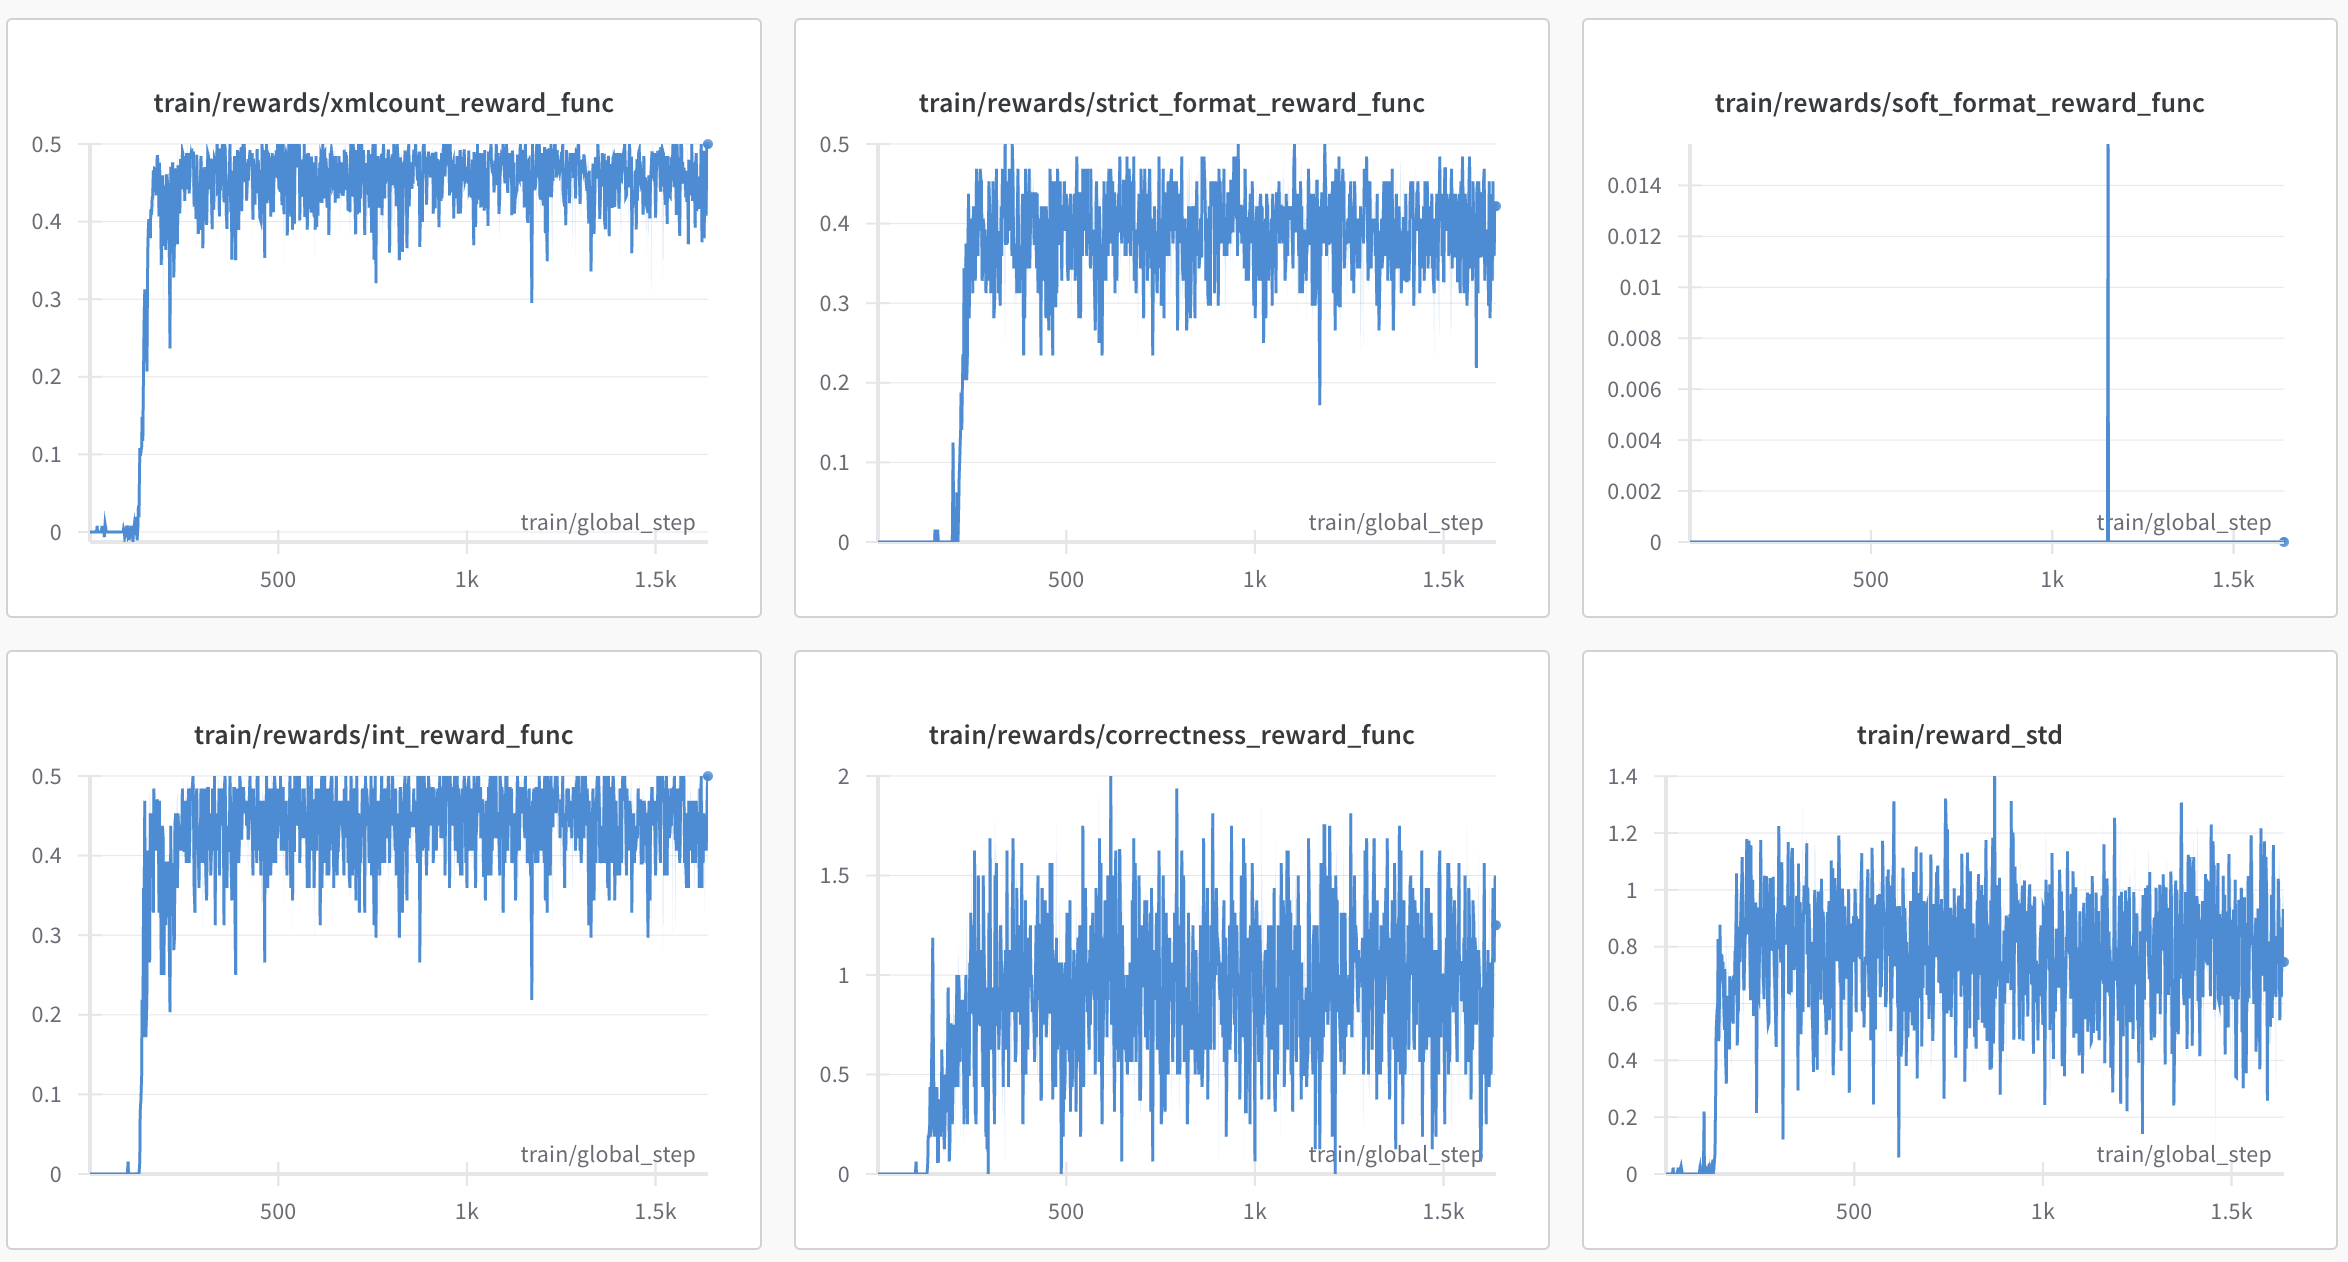